# FITTING A BOND YIELD CURVE

In this notebook I show how you can build a yield curve and fit it parametrically using a number of curve functions

In [1]:
import datetime as dt
import pandas as pd

In [2]:
from financepy.utils import *
from financepy.products.bonds import *
from financepy.market.curves import *

####################################################################
#  FINANCEPY BETA Version 0.350 - This build: 30 Apr 2024 at 21:20 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



## Load Bond Data

I have downloaded some bond price data from the UK DMO

In [3]:
bond_dataframe = pd.read_csv('./data/giltbondprices.txt', sep='\t')

We'll use mid-market prices for our analysis

In [4]:
bond_dataframe['mid'] = 0.5*(bond_dataframe['bid'] + bond_dataframe['ask'])

We need to use UK bond conventions

In [5]:
dc_type, frequencyType, settle_days, exDiv, calendar = get_bond_market_conventions(BondMarkets.UNITED_KINGDOM)

In [6]:
today = Date(18,9,2012)
settle_dt = today.add_weekdays(settle_days)
print("Settles:", settle_dt)

Settles: 19-SEP-2012


In [7]:
bonds = []
ylds = []

In [8]:
for index, bond in bond_dataframe.iterrows():

    date_string = bond['maturity']
    mat_date_time = dt.datetime.strptime(date_string, '%d-%b-%y')
    maturity_dt = from_datetime(mat_date_time)
    issue_dt = Date(maturity_dt.d, maturity_dt.m, 2000)
    coupon = bond['coupon']/100.0
    clean_price = bond['mid']
    bond = Bond(issue_dt, maturity_dt, coupon, frequencyType, dc_type)
    yld = bond.yield_to_maturity(settle_dt, clean_price)
    bonds.append(bond)
    ylds.append(yld)

## Yield Curve Fitting

### Cubic Polynomial Curve

We can fit the yields to a polynomial. The default is a cubic so no argument is needed. 

In [9]:
curveFunction = CurveFitPolynomial()

In [10]:
fitted_curve = BondYieldCurve(settle_dt, bonds, ylds, curveFunction)

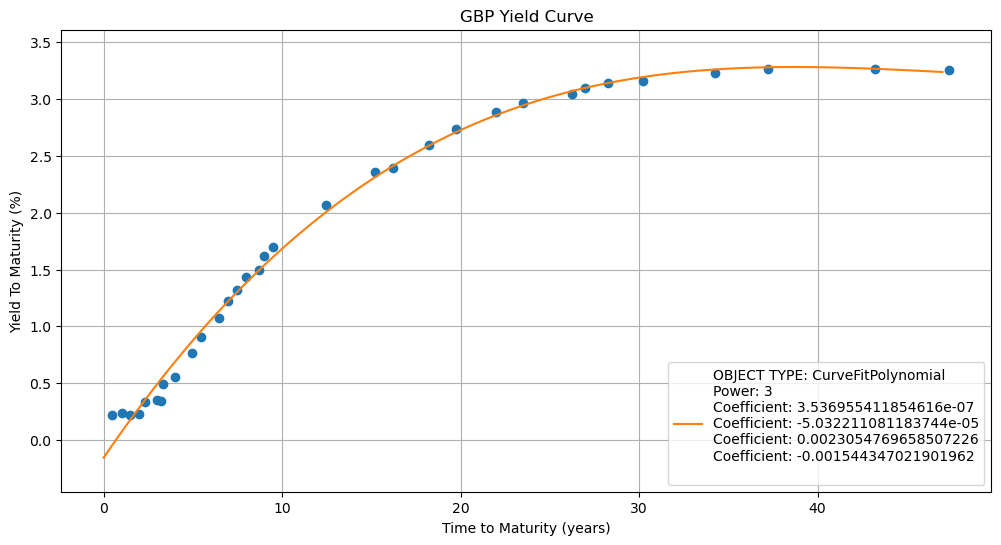

In [11]:
fitted_curve.plot("GBP Yield Curve")

We can get the coefficients as follows

In [12]:
curveFunction.coeffs

array([ 3.53695541e-07, -5.03221108e-05,  2.30547697e-03, -1.54434702e-03])

These coefficients start with the highest power of the time to maturity and end with the constant 

To get a specific yield we can call the function interp_yield

In [13]:
fitted_curve.interp_yield(20.0)*100

2.726591229986121

In [14]:
times = np.linspace(0,10,10)

In [15]:
fitted_curve.interp_yield(times)*100

array([-0.1544347 ,  0.09556532,  0.33343123,  0.55945415,  0.77392517,
        0.97713542,  1.16937598,  1.35093798,  1.52211252,  1.68319071])

### Quintic Polynomial

We can add more parameters using a Quintic polynomial.

In [16]:
curveFunction = CurveFitPolynomial(5)

In [17]:
fitted_curve = BondYieldCurve(settle_dt, bonds, ylds, curveFunction)

In [18]:
curveFunction.coeffs

array([-1.44771535e-09,  1.78395721e-07, -7.41468170e-06,  9.06222841e-05,
        1.35360732e-03,  4.15140112e-07])

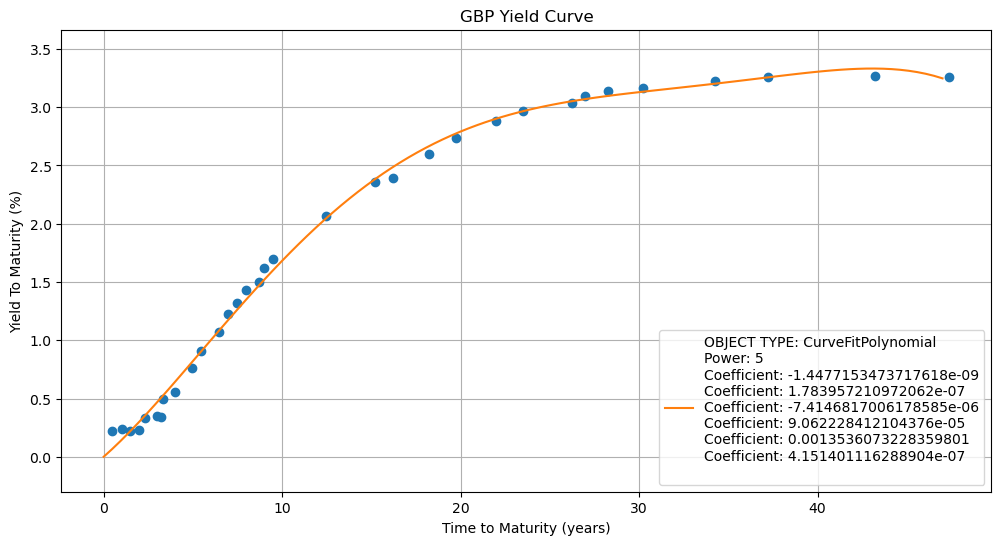

In [19]:
fitted_curve.plot("GBP Yield Curve")

The fit is slightly better.

Vectorisation works

In [20]:
fitted_curve.interp_yield(times)*100

array([4.15140112e-05, 1.60640106e-01, 3.37885261e-01, 5.26616437e-01,
       7.22266817e-01, 9.20833892e-01, 1.11885004e+00, 1.31335309e+00,
       1.50185693e+00, 1.68232208e+00])

### Nelson-Siegel Parametric Curve

We can fit the bond yields using the Nelson-Siegel curve

In [21]:
curveFunction = CurveFitNelsonSiegel()

In [22]:
fitted_curve = BondYieldCurve(settle_dt, bonds, ylds, curveFunction)

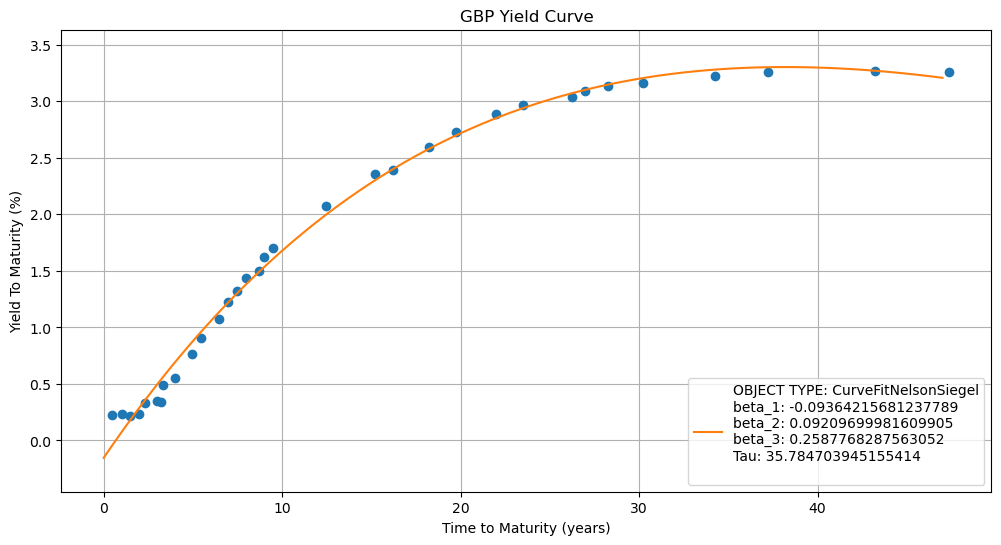

In [23]:
fitted_curve.plot("GBP Yield Curve")

We can access the underlying Nelson-Siegel parameters

In [24]:
print("beta_1 %12.8f"% curveFunction.beta_1)
print("beta_2 %12.8f"% curveFunction.beta_2)
print("beta_3 %12.8f"% curveFunction.beta_3)
print("tau   %12.8f"% curveFunction.tau)

beta_1  -0.09364216
beta_2   0.09209700
beta_3   0.25877683
tau    35.78470395


Vectorisation works

In [25]:
fitted_curve.interp_yield(times)*100

array([-0.15385902,  0.09750209,  0.33634915,  0.56251199,  0.77646064,
        0.97864931,  1.16951681,  1.34948709,  1.51896974,  1.6783604 ])

### Nelson-Siegel-Svensson Parametric Curve

There are two more parameters in this parametric curve.

In [26]:
curveFunction = CurveFitNelsonSiegelSvensson()

In [27]:
fitted_curve = BondYieldCurve(settle_dt, bonds, ylds, curveFunction)

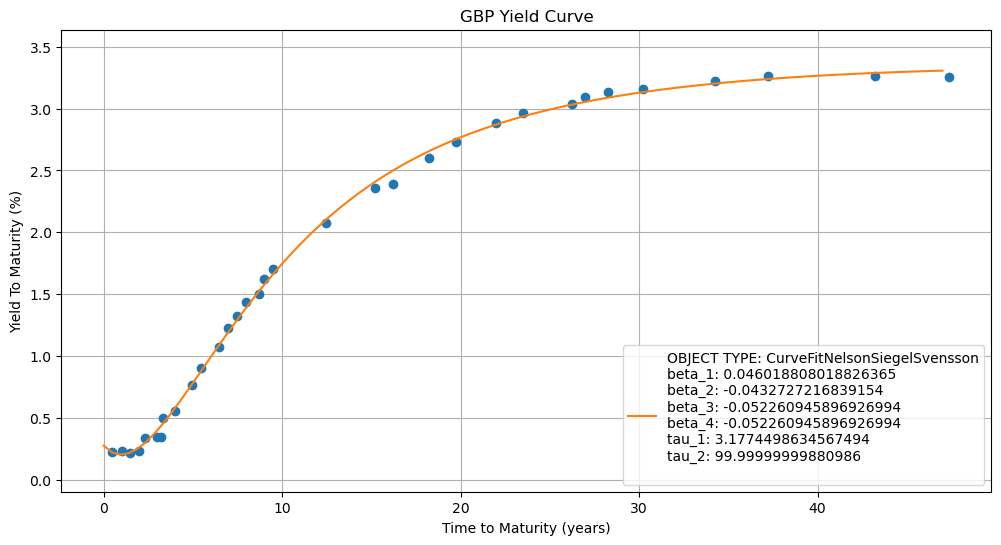

In [28]:
fitted_curve.plot("GBP Yield Curve")

Once again we can access the parameters

In [29]:
print("beta_1 %12.8f"% curveFunction.beta_1)
print("beta_2 %12.8f"% curveFunction.beta_2)
print("beta_3 %12.8f"% curveFunction.beta_3)
print("beta_4 %12.8f"% curveFunction.beta_4)
print("tau_1  %12.8f"% curveFunction.tau_1)
print("tau_2  %12.8f"% curveFunction.tau_2)

beta_1   0.04601881
beta_2  -0.04327272
beta_3  -0.05226095
beta_4  -0.03756484
tau_1    3.17744986
tau_2  100.00000000


Internally I have imposed a bound of [1,100] on tau_2. I can override this. This is what is used internally.

In [30]:
bounds = [(0, -1, -1, -1, 0, 1), (1, 1, 1, 1, 10, 100)]

I change it to

In [31]:
bounds = [(0, -1, -1, -1, 0, 1), (1, 1, 1, 1, 10, 1000)]

In [32]:
curveFunction = CurveFitNelsonSiegelSvensson(bounds=bounds)

In [33]:
fitted_curve = BondYieldCurve(settle_dt, bonds, ylds, curveFunction)

In [34]:
print("beta_1 %12.8f"% curveFunction.beta_1)
print("beta_2 %12.8f"% curveFunction.beta_2)
print("beta_3 %12.8f"% curveFunction.beta_3)
print("beta_4 %12.8f"% curveFunction.beta_4)
print("tau_1  %12.8f"% curveFunction.tau_1)
print("tau_2  %12.8f"% curveFunction.tau_2)

beta_1   0.04430037
beta_2  -0.04153519
beta_3  -0.05107468
beta_4  -0.22564902
tau_1    3.13419319
tau_2  999.99999996


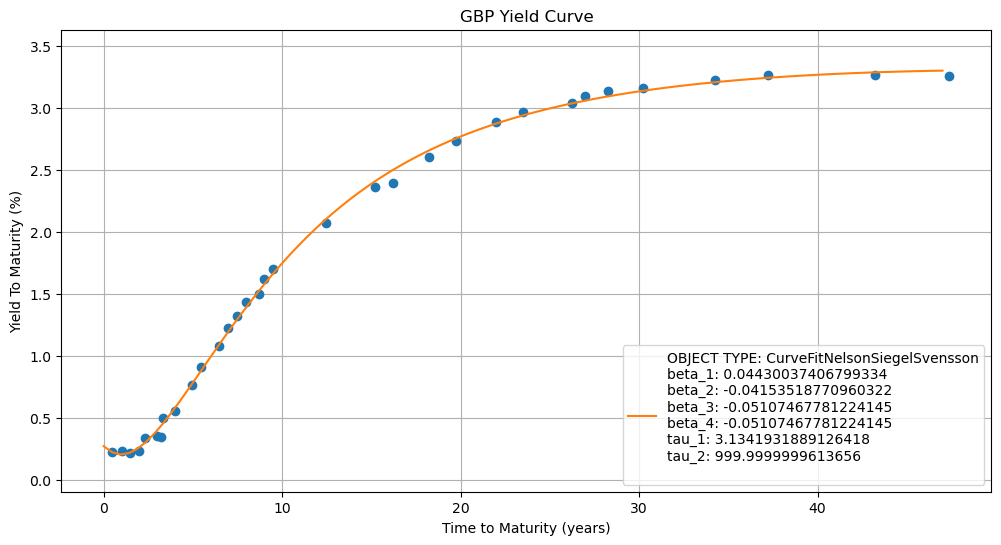

In [35]:
fitted_curve.plot("GBP Yield Curve")

It is clear that the parameter tau_2 wants to head to infinity - reducing to the Nelson-Siegel parametrisation.

Vectorisation works

In [36]:
fitted_curve.interp_yield(times)*100

array([0.2695003 , 0.20311555, 0.28484323, 0.45424336, 0.667873  ,
       0.89835085, 1.12894735, 1.34992072, 1.55604868, 1.74497612])

### B-Splines

Splines give us more flexibility and ensure smoothness. Internally I put knots at 1, 3, 5 and 10 years. 

In [37]:
curveFunction = CurveFitBSpline()
fitted_curve = BondYieldCurve(settle_dt, bonds, ylds, curveFunction)

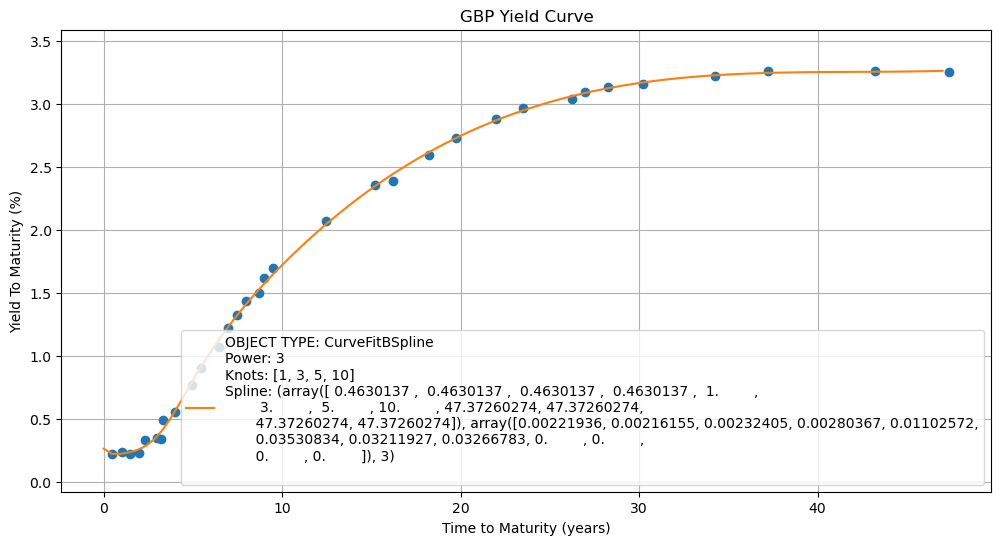

In [38]:
fitted_curve.plot("GBP Yield Curve")

We can recover the parameters of the spline.

In [39]:
curveFunction.spline

(array([ 0.4630137 ,  0.4630137 ,  0.4630137 ,  0.4630137 ,  1.        ,
         3.        ,  5.        , 10.        , 47.37260274, 47.37260274,
        47.37260274, 47.37260274]),
 array([0.00221936, 0.00216155, 0.00232405, 0.00280367, 0.01102572,
        0.03530834, 0.03211927, 0.03266783, 0.        , 0.        ,
        0.        , 0.        ]),
 3)

Vectorisation works.

In [40]:
fitted_curve.interp_yield(times)*100

array([0.26306369, 0.22601011, 0.27452407, 0.4183769 , 0.6700895 ,
       0.93767122, 1.1718964 , 1.37665168, 1.55813287, 1.72253582])

You can change the power of the spline

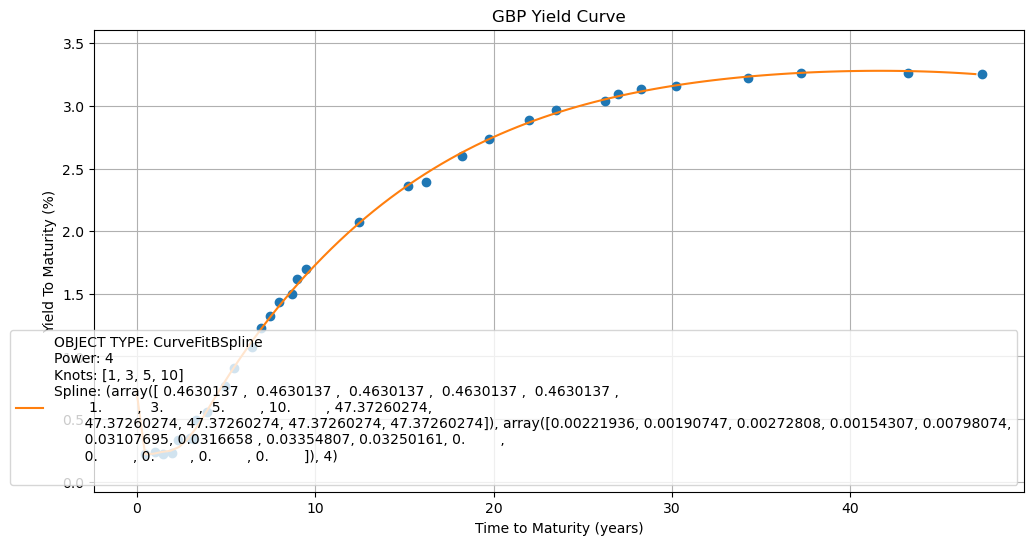

In [41]:
curveFunction = CurveFitBSpline(4)
fitted_curve = BondYieldCurve(settle_dt, bonds, ylds, curveFunction)
fitted_curve.plot("GBP Yield Curve")

This may not be what you want ! Let's see if 5 is better.

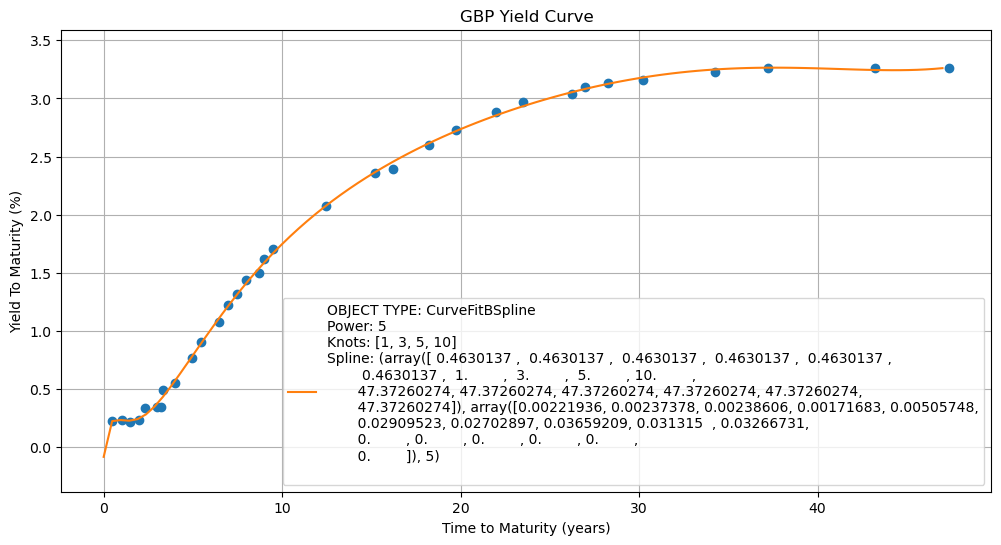

In [42]:
curveFunction = CurveFitBSpline(5)
fitted_curve = BondYieldCurve(settle_dt, bonds, ylds, curveFunction)
fitted_curve.plot("GBP Yield Curve")

Probably best to stick with a cubic B-spline.

## Inspecting the curve object


For each curve type you can examine the inner details of the calibration

In [43]:
fitted_curve.curve_fit.knots

[1, 3, 5, 10]

In [44]:
fitted_curve.curve_fit.power

5

In [45]:
fitted_curve.curve_fit.spline

(array([ 0.4630137 ,  0.4630137 ,  0.4630137 ,  0.4630137 ,  0.4630137 ,
         0.4630137 ,  1.        ,  3.        ,  5.        , 10.        ,
        47.37260274, 47.37260274, 47.37260274, 47.37260274, 47.37260274,
        47.37260274]),
 array([0.00221936, 0.00237378, 0.00238606, 0.00171683, 0.00505748,
        0.02909523, 0.02702897, 0.03659209, 0.031315  , 0.03266731,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 5)

Copyright (c) 2019, Dominic O'Kane 